In [126]:
from loaders import *
from linegraph import *
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from linegraph import build_line_graph_2
import seaborn as sn

def load(name):
    with open('{}.pickle'.format(str(name)), 'rb') as handle:
        b = pickle.load(handle)
        return b

def save(d, name):
    with open('{}.pickle'.format(str(name)), 'wb') as handle:
        pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

def get_number_nodes(h):
    nodes = set()
    for e in h:
        for n in e:
            nodes.add(n)
    return len(nodes)

def get_degree(h):
    deg = {}
    for e in h:
        for n in e:
            if n not in deg:
                deg[n] = 1
            else:
                deg[n]+=1

    return deg

In [127]:
name = 'high_school'

In [128]:
if name == 'high_school':
    h = load_high_school(1000000000)
elif name == 'primary_school':
    h = load_primary_school(1000000000)
elif name == 'hospital':
    h = load_hospital(1000000000)
elif name[:4] == 'PACS':
    S = int(name[4])
    h = load_PACS_single(S)
elif name == 'phys-soc':
    h = load('hypergraph_physics_society')
elif name == 'enron':
    h = load_enron(1000000000)
elif name == 'ndc_classes':
    h = load_NDC_classes(100000000)
elif name == 'baboons':
    h = load_babbuini(10000000000)

h = list(set(h))
lg = build_line_graph_2(h, name)

7818
Reading pickle
Line graph loaded


In [129]:
ids = lg['ids']
cc = lg['largest_cc']
ids = {v: k for k, v in ids.items()}

h = []
for id in cc:
    h.append(ids[id])

In [130]:
print("Info : nodes {} edges {}".format(get_number_nodes(h), len(h)))
D = 2

X = np.arange(len(h)).reshape(-1, 1)
print(X.shape)

def dist(sa, sb):
    sa = set(sa)
    sb = set(sb)
    i = sa.intersection(sb)
    u = sa.union(sb)

    return 1 - len(i) / len(u)

X = []
adj = {}
edge_to_id = {}

cont = 0
for e in h:
    e = tuple(sorted(e))
    edge_to_id[e] = cont
    for n in e:
        if n not in adj:
            adj[n] = []
        adj[n].append(e)
    cont += 1

print("Computing distances")

G = nx.Graph()
G.add_nodes_from([i for i in range(len(h))])

try:
    X = load("distances{}_{}".format(D, name))
except:
    vis = {}
    c = 0
    for n in adj:
        print("Done {} of {}".format(c, len(adj)))
        for i in range(len(adj[n])-1):
            for j in range(i+1, len(adj[n])):
                k = tuple(sorted((edge_to_id[adj[n][i]], edge_to_id[adj[n][j]])))
                e_i = set(adj[n][i])
                e_j = set(adj[n][j])
                if k not in vis:
                    w = dist(e_i, e_j)
                    if w > 0:
                        G.add_edge(edge_to_id[adj[n][i]], edge_to_id[adj[n][j]], weight=w)
                    vis[k] = True
        c+=1

    X = nx.to_numpy_array(G, weight='weight', nonedge=1.0)

    save(X, "distances{}_{}".format(D, name))
    save(G, "graph_distances{}_{}".format(D, name))

print("dist computed")

np.fill_diagonal(X, 0.0)
dist_matrix = ssd.squareform(X)
cluster = linkage(dist_matrix, method='average')

Info : nodes 327 edges 7818
(7818, 1)
Computing distances
dist computed


In [131]:
from scipy.cluster.hierarchy import *
plt.rcParams.update({'font.size': 22})

In [132]:
from scipy.cluster.hierarchy import fcluster

heights = [float(i) * 0.01 for i in range(101)]

0 7818 1.0
1 7818 1.0
2 7818 1.0
3 7818 1.0
4 7818 1.0
5 7818 1.0
6 7818 1.0
7 7818 1.0
8 7818 1.0
9 7818 1.0
10 7818 1.0
11 7818 1.0
12 7818 1.0
13 7818 1.0
14 7818 1.0
15 7818 1.0
16 7818 1.0
17 7818 1.0
18 7818 1.0
19 7818 1.0
20 7811 0.9991046303402404
21 7811 0.9991046303402404
22 7811 0.9991046303402404
23 7811 0.9991046303402404
24 7811 0.9991046303402404
25 7611 0.9735226400613968
26 7611 0.9735226400613968
27 7611 0.9735226400613968
28 7611 0.9735226400613968
29 7611 0.9735226400613968
30 7611 0.9735226400613968
31 7611 0.9735226400613968
32 7608 0.9731389102072141
33 7602 0.9723714504988488
34 5894 0.7539012535175237
35 5894 0.7539012535175237
36 5894 0.7539012535175237
37 5894 0.7539012535175237
38 5873 0.7512151445382451
39 5872 0.7510872345868509
40 5807 0.7427730877462266
41 5807 0.7427730877462266
42 5604 0.7168073676132003
43 5603 0.7166794576618061
44 5591 0.7151445382450755
45 5585 0.7143770785367102
46 5584 0.714249168585316
47 5568 0.7122026093630084
48 5565 0.71181

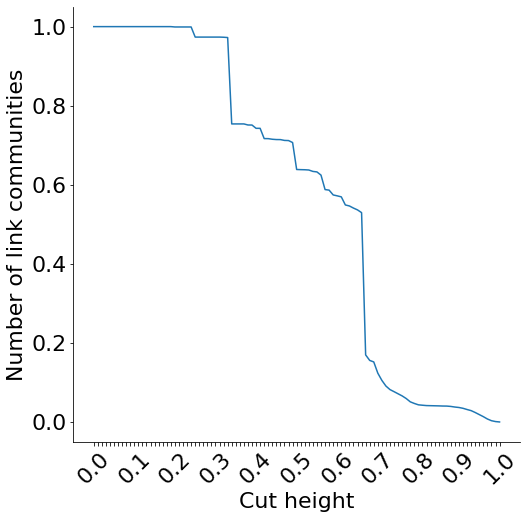

In [133]:
cut_at_levels = []

m = len(h)

for i in range(101):
    ccc = len(set(fcluster(cluster, t=float(i)*0.01, criterion='distance')))
    cut_at_levels.append(ccc / m)
    print(i, ccc, ccc / m)

import matplotlib.pyplot as plt

plt.xlabel("Cut height")
plt.ylabel("Number of link communities")
fake_labels = []
for i in range(len(heights)):
    if i % 10 == 0:
        fake_labels.append("{}".format(round(heights[i], 3)))
    else:
        fake_labels.append(" ")
plt.xticks(range(len(heights)), fake_labels, rotation=45)
sn.despine()
save(cut_at_levels, "{}".format(name))
plt.plot(cut_at_levels)

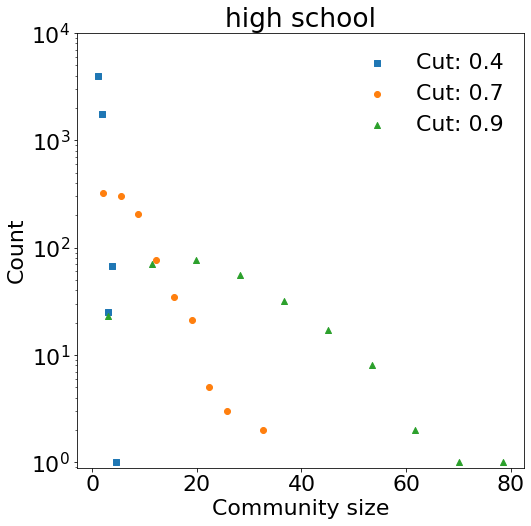

In [134]:
labels = []
Xs = []
Ys = []
for cut_level in [0.40, 0.70, 0.90]:
    full_dendro = fcluster(cluster, t=cut_level, criterion='distance')

    Y = full_dendro
    d = {}
    for y in Y:
        if y not in d:
            d[y] = 1
        else:
            d[y] += 1

    labels.append("Cut: {}".format(cut_level))
    tmp = plt.hist(d.values())
    y, x = tmp[0], tmp[1]
    x = x[:len(x)-1]
    Xs.append(x)
    Ys.append(y)

plt.clf()
if name == 'high_school':
    name1 = "high school"
elif name == 'hospital':
    name1 = "hospital"
elif name == 'phys-soc':
    name1 = "phys-soc"
elif name == 'ndc_classes':
    name1 = "NDC Classes"
elif name == 'mathoverflow':
    name1 = "math overflow"
else:
    name1 = name
plt.title("{}".format(name1))
plt.ylabel("Count")
plt.xlabel("Community size")
plt.yscale("log")
plt.ylim(0, 10000)
markers = ["," , "o" , "^"]
for i in range(len(Xs)):
    x = Xs[i]
    y = Ys[i]
    l = labels[i]
    plt.scatter(x=x, y=y, label=l, marker=markers[i])
plt.legend(frameon=False)
plt.savefig("fig4_{}-0.svg".format(name))

In [135]:
def edge_label2node_labels(h, labels):
    nodes = {}
    for i in range(len(labels)):
        label_arco = labels[i]
        for nodo in h[i]:
            if nodo not in nodes:
                nodes[nodo] = []
                nodes[nodo].append(label_arco)
            else:
                nodes[nodo].append(label_arco)
    return nodes

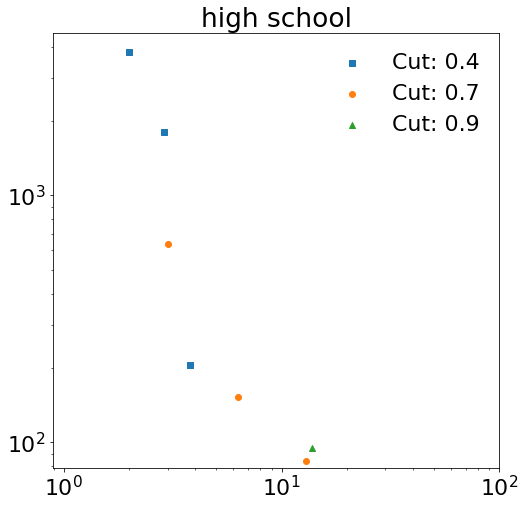

In [136]:
labels = []
Xs = []
Ys = []
for cut_level in [0.40, 0.70, 0.90]:
    full_dendro = fcluster(cluster, t=cut_level, criterion='distance')

    Y = full_dendro
    d = {}
    for y in Y:
        if y not in d:
            d[y] = 1
        else:
            d[y] += 1
    num_communities = len(d)

    node_labels = edge_label2node_labels(h, Y)

    node_num_comm = {}
    for k in node_labels:
        node_num_comm[k] = len(node_labels[k])

    d = {}
    d_n = {}
    for e in range(len(Y)):
        comm_e = Y[e]
        edge = h[e]
        if comm_e not in d:
            d[comm_e] = 1
            d_n[comm_e] = set(edge)
        else:
            d[comm_e] += 1
            for node_tmp in edge:
                d_n[comm_e].add(node_tmp)
            

    for k in d_n:
        d_n[k] = len(d_n[k])

    labels.append("Cut: {}".format(cut_level))
    tmp = plt.hist(d_n.values())
    y, x = tmp[0], tmp[1]
    x = x[:len(x)-1]
    Xs.append(x)
    Ys.append(y)

plt.clf()
if name == 'high_school':
    name1 = "high school"
elif name == 'hospital':
    name1 = "hospital"
elif name == 'phys-soc':
    name1 = "phys-soc"
elif name == 'ndc_classes':
    name1 = "NDC Classes"
else:
    name1 = name
plt.title("{}".format(name1))

plt.yscale("log")
plt.xscale("log")
plt.xlim(0, 100)
markers = ["," , "o" , "^"]
for i in range(len(Xs)):
    x = Xs[i]
    y = Ys[i]
    l = labels[i]
    plt.scatter(x=x, y=y, label=l, marker=markers[i])
plt.legend(frameon=False)
plt.savefig("fig4_{}-1.svg".format(name))

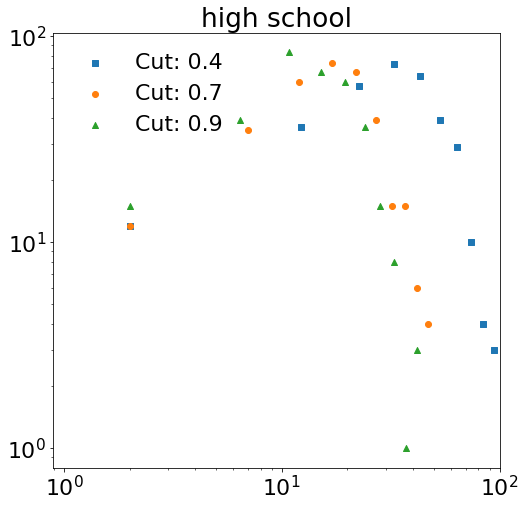

In [137]:
labels = []
Xs = []
Ys = []
for cut_level in [0.40, 0.70, 0.90]:
    full_dendro = fcluster(cluster, t=cut_level, criterion='distance')

    Y = full_dendro
    d = {}
    for y in Y:
        if y not in d:
            d[y] = 1
        else:
            d[y] += 1
    num_communities = len(d)

    node_labels = edge_label2node_labels(h, Y)

    node_num_comm = {}
    for k in node_labels:
        node_num_comm[k] = len(node_labels[k])

    d_n = {}
    for e in range(len(Y)):
        comm_e = Y[e]
        edge = h[e]
        if comm_e not in d:
            d[comm_e] = 1
        else:
            d[comm_e] += 1
        for node_tmp in edge:
            if node_tmp not in d_n:
                d_n[node_tmp] = set()
                d_n[node_tmp].add(comm_e)
            else:
                d_n[node_tmp].add(comm_e)
            

    for k in d_n:
        d_n[k] = len(d_n[k])

    #labels.append("Cut: {}, num. comm: {}".format(cut_level, len(d)))
    labels.append("Cut: {}".format(cut_level))
    tmp = plt.hist(d_n.values())
    y, x = tmp[0], tmp[1]
    x = x[:len(x)-1]
    Xs.append(x)
    Ys.append(y)

plt.yscale("log")

plt.clf()
if name == 'high_school':
    name1 = "high school"
elif name == 'hospital':
    name1 = "hospital"
elif name == 'phys-soc':
    name1 = "phys-soc"
elif name == 'ndc_classes':
    name1 = "NDC Classes"

plt.title("{}".format(name1))
plt.yscale("log")
plt.xscale("log")
plt.xlim(0, 100)
markers = ["," , "o" , "^"]
for i in range(len(Xs)):
    x = Xs[i]
    y = Ys[i]
    l = labels[i]
    plt.scatter(x=x, y=y, label=l, marker=markers[i])
plt.legend(frameon=False)
plt.savefig("fig4_{}-2.svg".format(name))

In [138]:
def participation_coefficient(labels):
    s = 0
    c = {}
    for l in labels:
        if l not in c:
            c[l] = 1
        else:
            c[l] += 1
    for k in c:
        s = s + (c[k] / len(labels))**2
    return num_communities / (num_communities-1)*(1 - s)

def entropy(labels):
    from math import log2
    s = 0
    c = {}
    for l in labels:
        if l not in c:
            c[l] = 1
        else:
            c[l] += 1
    for k in c:
        p = c[k] / len(labels)
        s = s + (p*log2(p))
    return -s

In [139]:
node_participation = {}

for k in node_labels:
    node_participation[k] = participation_coefficient(node_labels[k])
    #node_participation[k] = entropy(node_labels[k])
    #node_participation[k] = len(set(node_labels[k]))

Data loaded
327
Vectors computed
327
0 of 327
1 of 327
2 of 327
3 of 327
4 of 327
5 of 327
6 of 327
7 of 327
8 of 327
9 of 327
10 of 327
11 of 327
12 of 327
13 of 327
14 of 327
15 of 327
16 of 327
17 of 327
18 of 327
19 of 327
20 of 327
21 of 327
22 of 327
23 of 327
24 of 327
25 of 327
26 of 327
27 of 327
28 of 327
29 of 327
30 of 327
31 of 327
32 of 327
33 of 327
34 of 327
35 of 327
36 of 327
37 of 327
38 of 327
39 of 327
40 of 327
41 of 327
42 of 327
43 of 327
44 of 327
45 of 327
46 of 327
47 of 327
48 of 327
49 of 327
50 of 327
51 of 327
52 of 327
53 of 327
54 of 327
55 of 327
56 of 327
57 of 327
58 of 327
59 of 327
60 of 327
61 of 327
62 of 327
63 of 327
64 of 327
65 of 327
66 of 327
67 of 327
68 of 327
69 of 327
70 of 327
71 of 327
72 of 327
73 of 327
74 of 327
75 of 327
76 of 327
77 of 327
78 of 327
79 of 327
80 of 327
81 of 327
82 of 327
83 of 327
84 of 327
85 of 327
86 of 327
87 of 327
88 of 327
89 of 327
90 of 327
91 of 327
92 of 327
93 of 327
94 of 327
95 of 327
96 of 327
97 

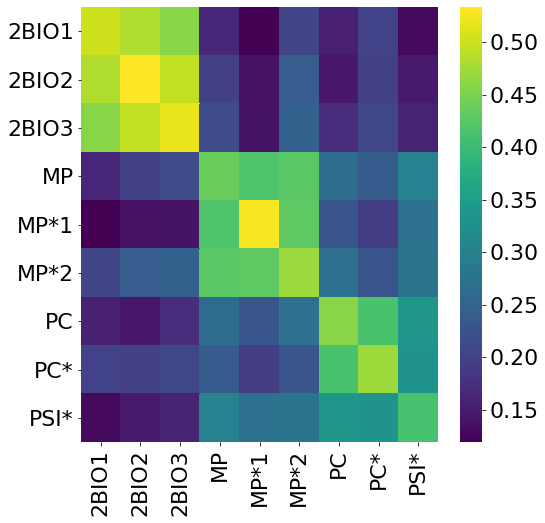

In [140]:

import numpy as np

def jaccard_binary(x,y):
    """A function for finding the similarity between two binary vectors"""
    intersection = np.logical_and(x, y)
    union = np.logical_or(x, y)
    similarity = intersection.sum() / float(union.sum())
    return similarity

def dict2frame(D_pair_value):
    # Extract keys and values
    k = np.array(D_pair_value.keys())
    v = np.array(D_pair_value.values())

    # Get row, col indices from keys
    idx = (np.fromstring(k.tobytes(),dtype=np.uint8)-65).reshape(-1,2)

    # Setup output array and using row,col indices set values from v
    N = idx.max()+1
    out = np.zeros((N,N),dtype=v.dtype)
    out[idx[:,0],idx[:,1]] = v
    out[idx[:,1],idx[:,0]] = v

    header = list("".join([chr(item) for item in np.arange(N)+65]))
    return pd.DataFrame(out,index=header, columns=header)

full_dendro = fcluster(cluster, t=0.99, criterion='distance')
Y = full_dendro

node_labels = edge_label2node_labels(h, Y)
if name == 'hospital':
    roles = load_hospital_meta()
elif name == 'high_school':
    roles = load_high_school_meta()
elif name == 'primary_school':
    roles = load_primary_school_meta()

data = {}

print("Data loaded")
print(len(node_labels.keys()))

for k in sorted(node_labels.keys()):
    data[k] = {}
    data[k]['comm'] = [0 for _ in range(len(set(Y)))]
    for l in node_labels[k]:
        data[k]['comm'][l-1] = 1
    data[k]['role'] = roles[k]
res = {}
print("Vectors computed")
print(len(data))
t = 0
for i in data:
    print("{} of {}".format(t, len(data)))
    t+=1
    for j in data:
        a = data[i]
        b = data[j]
        s = jaccard_binary(a['comm'], b['comm'])
        z = tuple(sorted(list(tuple([a['role'], b['role']]))))
        if z not in res:
            res[z] = []
        res[z].append(s)
for z in res:
    res[z] = sum(res[z]) / len(res[z])

keys = set()
for k in res:
    a = k[0]
    b = k[1]
    keys.add(a)
    keys.add(b)
keys = list(sorted(list(keys)))

distances = []

for i in keys:
    tmp = []
    for j in keys:
        z = tuple(sorted(list(tuple([i, j]))))
        tmp.append(res[z])
    distances.append(tmp)
distances = pd.DataFrame(distances)
x_axis_labels = keys

print("Computing heatmap")

sn.heatmap(distances, cmap='viridis',xticklabels=x_axis_labels, yticklabels=x_axis_labels)
plt.savefig("similarity-meta-{}.svg".format(name))

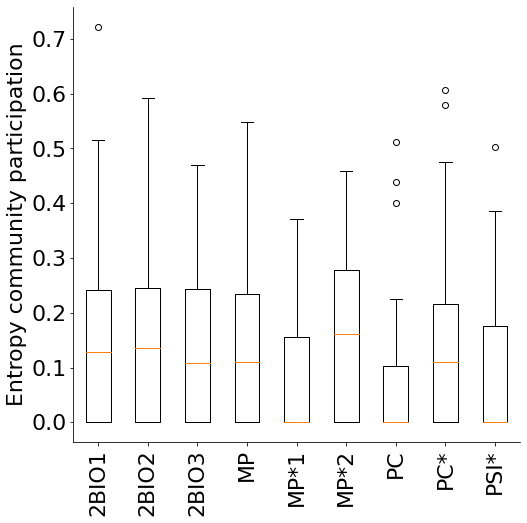

In [141]:
import numpy as np

full_dendro = fcluster(cluster, t=0.999, criterion='distance')
Y = full_dendro

node_labels = edge_label2node_labels(h, Y)
if name == 'hospital':
    roles = load_hospital_meta()
elif name == 'high_school':
    roles = load_high_school_meta()
elif name == 'primary_school':
    roles = load_primary_school_meta()

data = {}
data1 = {}

for k in sorted(node_labels.keys()):
    r = roles[k]
    if r not in data:
        data[r] = []
    if r not in data1:
        data1[r] = []
    data1[r].append(len(set(node_labels[k])))
    data[r].append(entropy(node_labels[k]))
data = dict(sorted(data.items()))
df = data.values()
plt.boxplot(df, widths = 0.5,labels=list(data.keys()))

plt.xticks(rotation=90)
plt.ylabel("Entropy community participation")

sn.despine()
plt.savefig("entropy-meta-{}.svg".format(name))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

[0.7140736866258741, 0.8202503841099484] [42.0, 65.22]
[0.7140736866258741, 0.8202503841099484]
[42.0, 65.22]
2BIO3
[0.7764820590305356, 0.5258621762715748, 0.8077555882784265, 0.8210254748066721, 0.8312000174643256, 0.6432705616379081, 0.8223929780639908, 0.9187567987567988, 0.8666180758017493, 0.7005079739176192, 0.8818835485502153, 0.8281918081918082, 0.7133190546301892, 0.735818264575661, 0.8155136874145138, 0.8742903199282936, 0.80844897373823, 0.8911777947590621, 0.7334583818958819, 0.7607757867132868, 0.8299553806310562, 0.9001363636363637, 0.7493026821949317, 0.8778674646443242, 0.8184731245086275, 0.7051285399461209, 0.752104528985745, 0.7709225216150424, 0.8767794705294706, 0.6805720231325767, 0.7643713036275019, 0.5112939973225347, 0.9130411447742485, 0.7880746243376003, 0.664795700167601, 0.7635837815834914, 0.7350191682468731, 0.8802894327894328, 0.8424415091081758] [57, 53, 59, 73, 93, 147, 101, 75, 98, 73, 63, 70, 93, 65, 66, 83, 99, 99, 48, 80, 148, 100, 46, 99, 65, 59,

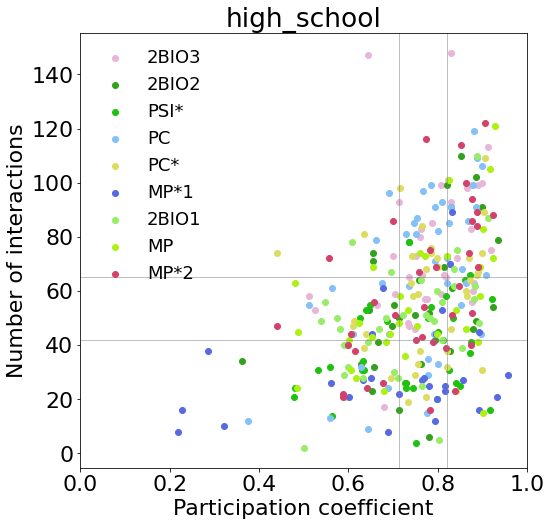

In [142]:
import matplotlib.pyplot as plt

if name == 'hospital':
    roles = load_hospital_meta()
    num_roles = set()
    for k in roles:
        num_roles.add(roles[k])
elif name == 'primary_school':
    roles = load_primary_school_meta()
    num_roles = set()
    for k in roles:
        num_roles.add(roles[k])
elif name == 'high_school':
    roles = load_high_school_meta()
    num_roles = set()
    for k in roles:
        num_roles.add(roles[k])
else:
    roles = {}
    for tmp in node_labels:
        roles[tmp] = 'no_role'
    num_roles = set(['no_role'])

role2color = {}
z = 0
for k in num_roles:
    if k not in role2color:
        role2color[k] = np.random.rand(3,)
        z+=1

x = []
y = []
colors = []
role = {}

for k in sorted(node_labels.keys()):
    R = roles[k]
    if R not in role:
        role[R] = {}
        role[R]['x'] = []
        role[R]['y'] = []
        role[R]['color'] = role2color[roles[k]]
    else:
        role[R]['x'].append(node_participation[k])
        role[R]['y'].append(node_num_comm[k])
    

plt.title("{}".format(name))
plt.xlabel("Participation coefficient")
plt.ylabel("Number of interactions")
#plt.xlim(0,1)
xs = []
rx = []
ys = []
ry = []

for k in role:
    for xx in role[k]['x']:
        xs.append(xx)
        rx.append(k)

for k in role:
    for yy in role[k]['y']:
        ys.append(yy)
        ry.append(k)

YMAX = max(ys)

percentiles_x = [np.percentile(xs, i) for i in [33, 66]]
percentiles_y = [np.percentile(ys, i) for i in [33, 66]]
print(percentiles_x, percentiles_y)
tmp = [percentiles_x[0], percentiles_x[1]]
tmp2 = [percentiles_y[0], percentiles_y[1]]
print(tmp)
print(tmp2)
plt.xlim(0, 1)

for i in tmp2:
    plt.axhline(y=i, color='grey', linestyle='-', linewidth=0.5)
for i in tmp:
    plt.axvline(x=i, color='grey', linestyle='-', linewidth=0.5)

def inside(v, a, b):
    if v <= a:
        return 1
    elif v >= a and v <= b:
        return 2
    else:
        return 3

res = {}
for k in list(role.keys())[:]:
    plt.scatter(x=role[k]['x'], y=role[k]['y'], c=role[k]['color'], label=k)
    #plt.scatter(x=role[k]['x'], y=role[k]['y'])
    res[k] = {}
    x = role[k]['x']
    y = role[k]['y']
    for i in range(len(x)):
        ke = (inside(x[i], percentiles_x[0], percentiles_x[1]), inside(y[i], percentiles_y[0], percentiles_y[1]))

        if ke in res[k]:
            res[k][ke] += 1
        else:
            res[k][ke] = 1
    print(k)
    print(x, y)

plt.legend(frameon=False, prop={'size': 18})
plt.savefig("roles-{}.pdf".format(name))